# Modified 3D PMRNN

## Module Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
# import cv2
import numpy as np
import matplotlib.pyplot as plt
from ViTReconstruction import Reconstruction

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 8,
    "LEARNING_RATE": 1e-3,
    "OPTIMIZER":'Adam',
    "PATCH_SIZE":16,
    "N_EPOCHS": 2,
    "N_FILTERS": 5,
    "INPUT_SHAPE":(256,256,1),
    "LATENT_SPACE_DIM" : 64,
    "REDUCED_DIMENSION" : 256,
    "N_HEADS" : 3,
    "HIDDEN_SIZE" : 256,
    "N_PATCHES" : 256,
    "N_LAYERS" : 1,
}

In [3]:
# ignorable
print("TensorFlow version:", tf.__version__)
# print("cv2 version:",cv2.__version__)
print("np version:",np.__version__)

TensorFlow version: 2.5.0
np version: 1.19.5


In [4]:
# import matplotlib

In [5]:
# ignorable
import sklearn
# print("matplotlib version:",matplotlib.__version__)
print("sklearn version:",sklearn.__version__)

sklearn version: 1.2.2


In [6]:
from tensorflow.keras import layers,losses #,Sequential,metrics
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * 
# from tensorflow.keras.layers import Layer
# from tensorflow.keras import optimizers 
# from tensorflow.keras.optimizers.experimental import SGD
# from tensorflow.image import ssim

## Load new Data

### reading data

In [13]:
import Utils
image_data = Utils.read_data("Berea_2d25um_binary.raw")
image_data.shape

(1000, 1000, 1000)

### Voxel extraction 

In [14]:
voxels = Utils.extract_subvolumes(image_data)
voxels.shape

(64, 250, 256, 256, 1)

In [15]:
del image_data

### Train and test data extraction

In [16]:
X_train = voxels[:-6]
X_test = voxels[-6:]

In [17]:
del voxels

In [18]:
len(X_train)

58

### Save Traited data for uses

In [19]:
with open('X_train.npy', 'wb') as f:
    np.save(f, X_train)

In [20]:
with open('X_test.npy', 'wb') as f:
    np.save(f, X_test)

## TensorFlow GPU setup

In [7]:
#from tensorflow.python.compiler.tensorrt import trt_convert as trt
device = tf.config.list_physical_devices("GPU")
print(device)  # Check if GPU devices are visible
print(tf.test.is_built_with_cuda())  # Check if TensorFlow is built with CUDA support
#print(trt.trt_utils._pywrap_py_utils.get_linked_tensorrt_version())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [22]:
# only on weak GPU
tf.config.experimental.set_memory_growth(device[0],True)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [8]:
tf.keras.backend.clear_session()

## Load Traited data for training (voxels)

In [24]:
X_train=np.load('X_train.npy')
X_train.shape

(58, 250, 256, 256, 1)

In [29]:
# for test only
X_train=X_train[:1]
with open('X_train_test.npy', 'wb') as f:
    np.save(f, X_train)
X_train.shape

(1, 250, 256, 256, 1)

In [8]:
X_train=np.load('X_train_test.npy')
X_train.shape

(1, 250, 256, 256, 1)

### idk

In [9]:
learnedVoxels = []
inferenceVoxels = []
for voxel in X_train:
    learnedVoxels.append(voxel[:-1])
    inferenceVoxels.append(voxel[1:])

# learnedVoxels = np.array(learnedVoxels)
# inferenceVoxels = np.array(inferenceVoxels)

## Training 

### Imports

In [10]:
from mealpy.swarm_based import GWO
from sklearn.preprocessing import LabelEncoder
import time
import pickle
from datetime import datetime

In [11]:
import mealpy
mealpy.__version__

'2.4.0'

### Lables

In [12]:
class Timer():
    def __init__(self,title=" ",p={}) -> None:
        self.title=title
        self.started=time.time()
        self.params=p
        print(f"{self.title} Started at : {datetime.fromtimestamp(self.started)}")
        self.ended=None
    def End(self):
        self.ended=time.time()
        print(f"{self.title} Ended at : {datetime.fromtimestamp(self.ended)} and it took {self.ended-self.started}s")
    def setParams(self,name,data):
        self.params[name]=data

    def toDuration(self):
        if self.ended == None:
            return -1
        return self.ended-self.started
    
    def __str__(self) -> str:
        return f"{self.title} Started at : {datetime.fromtimestamp(self.started)} | Ended at : {datetime.fromtimestamp(self.ended)} and it took {self.ended-self.started}s"

class TrainingData(Timer):
    def __init__(self,title=" ",p={}) -> None:
        super().__init__(title=title,p=p)
        self.samples=[]
    
    def SampleStarted(self,title=" ")->Timer:
        timer= Timer(title)
        self.samples.append(timer)
        return timer
    
    def __str__(self) -> str:
        return super().__str__()+" "+str(self.params)

In [13]:
OPT_ENCODER = LabelEncoder()
#OPT_ENCODER.fit(['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])
OPT_ENCODER.fit(['SGD', 'RMSprop', 'Adagrad', 'Adam'])
trainings_duration=[]
trainings_epochs=[]

### Solution Decodation function

In [14]:
def decode_solution(solution):
    batch_size = 2**int(solution[0])
    
    learning_rate = solution[1]
    
    opt_int = int(solution[2])
    opt = OPT_ENCODER.inverse_transform([opt_int])[0]
    
    epoch = 10 *int(solution[3])
    
    num_filters = int(solution[4])
    
    latent_space_dim = 2**int(solution[5])
    
    reduced_dim = 2**int(solution[6])
    
    n_heads  = int(solution[7]) 
    hidden_size = 2** int(solution[8])
    enc_layers =  int(solution[9])
    
    return [batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim,reduced_dim,n_heads,hidden_size,enc_layers]


### Objective Function

In [15]:
# import random
# # the range of float values
# start = 0.001
# end = 0.8
current_epoch=0

def objective_function(solution):
    tf.keras.backend.clear_session()
    global current_epoch
    print("\n###########################################################\n")
    print(f"\n--------------------------{current_epoch}--------------------------------\n")
    print("\n###########################################################\n")
    batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim ,reduced_dim,n_heads,hidden_size,enc_layers = decode_solution(solution)
    reconstruction = Reconstruction(inputShape=CONFIGURATION["INPUT_SHAPE"],
                                    latent_space_dim=latent_space_dim,
                                    reducedDimension=reduced_dim,
                                    num_conv_layers=num_filters,
                                    learning_rate=learning_rate,
                                    batch_size=batch_size,
                                    epochs=epoch,
                                    opt=opt,
                                    n_heads=n_heads,
                                    hidden_size=hidden_size,
                                    enc_layers=enc_layers,
                                    )
    #reconstruction.summary()
    reconstruction.compile()
    histories = []
    params = {
        "inputShape": CONFIGURATION["INPUT_SHAPE"],
        "latent_space_dim": latent_space_dim,
        "reducedDimension": reduced_dim,
        "num_conv_layers": num_filters,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epoch,
        "opt": opt,
        "n_heads" : n_heads, 
        "hidden_size" :  hidden_size,
        "enc_layers" : enc_layers,
    }
    trainingTime = TrainingData("Epoch Training", params)
    for i in range(len(learnedVoxels)):
        print(f"currently working one voxel : {i +1}, voxels left : {len(learnedVoxels)-(i+1)} ")
        sampleTime = trainingTime.SampleStarted(f"Voxel Training {i+1}")
#         histories.append(random.uniform(start, end))
        histories.append(reconstruction.train(learnedVoxels[i], inferenceVoxels[i]))
        sampleTime.End()

    trainingTime.setParams("loss",histories[-1].history['loss'][-1])
    trainingTime.End()
    trainings_duration.append(trainingTime)

    current_epoch+=1
    
    """ reconstruction.save( save_folder=f"results/model_{batch_size}_{learning_rate}_{opt}_{epoch}_{num_filters}_{latent_space_dim}_{reduced_dim}") """
#     return min(histories, key=lambda x: float('inf') if x is None else x)
    return histories[-1].history['loss'][-1]

### Configurations

In [16]:
LB = [3    , 0.001 , 0   , 2      ,  4  ,  6    , 7   , 3   , 6 ,  2 ,    6 ]
UB = [5.99 , 0.01  , 3.99, 4.99  ,  8.99,  8.99 , 9.99, 5.99, 7.99, 4.99, 8.99 ]


problem_dict = {
    "fit_func": objective_function,
    "lb": LB,
    "ub": UB,
    "minmax": "min",
    "verbose":True,
}
metaheuristic_configuration={
    "epoch":5,
    "pop_size":10
}
#save session for x epoch of the training
save_interval=1
session_file = 'gwo_session.pkl'


### Lunching the metaheuristic

In [18]:
# Check if a session file exists
if os.path.exists(session_file):
    # Load the session and resume from the saved state
    with open(session_file, 'rb') as f:
        session_data = pickle.load(f)
    model = session_data['model']
    best_solution = session_data['best_solution']
    current_iteration = session_data['current_iteration']
    print(best_solution)
    print("Resuming from iteration", current_iteration)
else:
    # Create a new GWO optimization session
    model = GWO.BaseGWO(problem_dict, epoch=metaheuristic_configuration["epoch"], pop_size=metaheuristic_configuration["pop_size"])
    best_solution = None
    current_iteration = 0
    trainings_epochs.append({"epoch" :current_iteration,"trainings" :trainings_duration,"best_solution":best_solution})
    trainings_duration=[]


###########################################################


--------------------------0--------------------------------


###########################################################

Instructions for updating:
Colocations handled automatically by placer.
Epoch Training Started at : 2023-06-19 22:25:52.629058
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-19 22:25:52.629058
Train on 249 samples
Epoch 1/20
249/249 [==============================] - 10s 42ms/sample - loss: 0.3420 - _calculate_reconstruction_loss: 0.1457 - _calculate_porosity_loss: 0.1772 - _calculate_kl_loss: 14.7799
Epoch 2/20
249/249 [==============================] - 2s 9ms/sample - loss: 0.1235 - _calculate_reconstruction_loss: 0.0480 - _calculate_porosity_loss: 0.0714 - _calculate_kl_loss: 3.3297
Epoch 3/20
249/249 [==============================] - 2s 9ms/sample - loss: 0.0754 - _calculate_reconstruction_loss: 0.0371 - _calculate_porosity_loss: 0.0349 - _calculate_kl_loss:

2023/06/19 10:26:49 PM, INFO, mealpy.swarm_based.GWO.BaseGWO: Solving single objective optimization problem.


Voxel Training 1 Ended at : 2023-06-19 22:26:49.181711 and it took 56.552653074264526s
Epoch Training Ended at : 2023-06-19 22:26:49.182712 and it took 56.553653955459595s


In [19]:
# Run the optimization loop
while current_iteration < metaheuristic_configuration["epoch"]:
    # Perform GWO iteration
    best_position, best_fitness = model.solve()

    # Update the best solution
    if best_solution is None or best_fitness < best_solution["fit"]:
        best_solution = {
            "fit": best_fitness,
            "position": best_position
        }

    current_iteration += 1
    trainings_epochs.append({"epoch" :current_iteration,"trainings" :trainings_duration,"best_solution":best_solution})
    trainings_duration=[]

    # Increment the iteration count
    # Save the session periodically
    if current_iteration % save_interval == 0:
        session_data = {
            "model": model,
            "best_solution": best_solution,
            "current_iteration": current_iteration
        }
        with open(session_file, 'wb') as f:
            pickle.dump(session_data, f)


###########################################################


--------------------------1--------------------------------


###########################################################

Epoch Training Started at : 2023-06-19 22:29:31.690488
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-19 22:29:31.690488
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 249 samples
Epoch 1/20
249/249 [==============================] - 7s 30ms/sample - loss: 0.2675 - _calculate_reconstruction_loss: 0.1042 - _calculate_porosity_loss: 0.1556 - _calculate_kl_loss: 4.4529
Epoch 2/20
249/249 [==============================] - 3s 12ms/sample - loss: 0.1294 - _calculate_reconstruction_loss: 0.0501 - _calculate_porosity_loss: 0.0791 - _calculate_kl_loss: 0.3401
Epoch 3/20
249/249 [==============================] - 3s 12ms/sample - loss: 0.0828 - _calculate_reconstruction_loss: 0.0380 - _calcula

2023/06/19 11:06:46 PM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 1, Current best: 0.021747794959798873, Global best: 0.021747794959798873, Runtime: 1070.68092 seconds


Voxel Training 1 Ended at : 2023-06-19 23:06:46.637695 and it took 116.34303331375122s
Epoch Training Ended at : 2023-06-19 23:06:46.637695 and it took 116.34303331375122s

###########################################################


--------------------------21--------------------------------


###########################################################

Epoch Training Started at : 2023-06-19 23:06:49.061236
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-19 23:06:49.061236
Train on 249 samples
Epoch 1/20
249/249 [==============================] - 6s 23ms/sample - loss: 0.1248 - _calculate_reconstruction_loss: 0.0447 - _calculate_porosity_loss: 0.0368 - _calculate_kl_loss: 41.1307
Epoch 2/20
249/249 [==============================] - 3s 11ms/sample - loss: 0.0637 - _calculate_reconstruction_loss: 0.0294 - _calculate_porosity_loss: 0.0036 - _calculate_kl_loss: 30.8027
Epoch 3/20
249/249 [==============================] - 3s 11ms/sample - loss: 0

2023/06/19 11:22:33 PM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 2, Current best: 0.021747794959798873, Global best: 0.021747794959798873, Runtime: 946.70372 seconds


Voxel Training 1 Ended at : 2023-06-19 23:22:33.341795 and it took 118.6153564453125s
Epoch Training Ended at : 2023-06-19 23:22:33.341795 and it took 118.6153564453125s

###########################################################


--------------------------31--------------------------------


###########################################################

Epoch Training Started at : 2023-06-19 23:22:35.825351
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-19 23:22:35.825351
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 6s 22ms/sample - loss: 0.1895 - _calculate_reconstruction_loss: 0.0678 - _calculate_porosity_loss: 0.0576 - _calculate_kl_loss: 60.7687
Epoch 2/30
249/249 [==============================] - 3s 11ms/sample - loss: 0.0674 - _calculate_reconstruction_loss: 0.0284 - _calculate_porosity_loss: 0.0040 - _calculate_kl_loss: 34.9916
Epoch 3/30
249/249 [==============================] - 3s 11ms/sample - loss: 0.0

2023/06/19 11:36:07 PM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 3, Current best: 0.021747794959798873, Global best: 0.021747794959798873, Runtime: 814.52745 seconds


Voxel Training 1 Ended at : 2023-06-19 23:36:07.870051 and it took 52.146668672561646s
Epoch Training Ended at : 2023-06-19 23:36:07.870051 and it took 52.146668672561646s

###########################################################


--------------------------41--------------------------------


###########################################################

Epoch Training Started at : 2023-06-19 23:36:10.294594
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-19 23:36:10.294594
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 6s 22ms/sample - loss: 0.1645 - _calculate_reconstruction_loss: 0.0589 - _calculate_porosity_loss: 0.0450 - _calculate_kl_loss: 57.4780
Epoch 2/30
249/249 [==============================] - 3s 11ms/sample - loss: 0.0531 - _calculate_reconstruction_loss: 0.0292 - _calculate_porosity_loss: 0.0036 - _calculate_kl_loss: 20.2295
Epoch 3/30
249/249 [==============================] - 3s 11ms/sample - loss: 0

2023/06/19 11:49:21 PM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 4, Current best: 0.021747794959798873, Global best: 0.021747794959798873, Runtime: 794.09395 seconds


Voxel Training 1 Ended at : 2023-06-19 23:49:21.964732 and it took 52.643779039382935s
Epoch Training Ended at : 2023-06-19 23:49:21.964732 and it took 52.643779039382935s

###########################################################


--------------------------51--------------------------------


###########################################################

Epoch Training Started at : 2023-06-19 23:49:24.403277
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-19 23:49:24.403277
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 6s 23ms/sample - loss: 0.1647 - _calculate_reconstruction_loss: 0.0528 - _calculate_porosity_loss: 0.0417 - _calculate_kl_loss: 67.1301
Epoch 2/30
249/249 [==============================] - 3s 11ms/sample - loss: 0.0487 - _calculate_reconstruction_loss: 0.0288 - _calculate_porosity_loss: 0.0037 - _calculate_kl_loss: 15.8832
Epoch 3/30
249/249 [==============================] - 3s 11ms/sample - loss: 0

2023/06/20 12:05:04 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 5, Current best: 0.019603500052927488, Global best: 0.019603500052927488, Runtime: 942.74060 seconds


Voxel Training 1 Ended at : 2023-06-20 00:05:04.706674 and it took 91.33543753623962s
Epoch Training Ended at : 2023-06-20 00:05:04.706674 and it took 91.33543753623962s

###########################################################


--------------------------61--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 00:05:06.574091
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 00:05:06.574091
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 5s 20ms/sample - loss: 0.4201 - _calculate_reconstruction_loss: 0.1952 - _calculate_porosity_loss: 0.2107 - _calculate_kl_loss: 10.6548
Epoch 2/40
249/249 [==============================] - 3s 11ms/sample - loss: 0.2392 - _calculate_reconstruction_loss: 0.0918 - _calculate_porosity_loss: 0.1434 - _calculate_kl_loss: 4.7337
Epoch 3/40
249/249 [==============================] - 3s 11ms/sample - loss: 0.17

2023/06/20 12:34:46 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 1, Current best: 0.0321844733623137, Global best: 0.0321844733623137, Runtime: 783.91489 seconds


Voxel Training 1 Ended at : 2023-06-20 00:34:46.313933 and it took 82.23539209365845s
Epoch Training Ended at : 2023-06-20 00:34:46.313933 and it took 82.23539209365845s

###########################################################


--------------------------81--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 00:34:48.915515
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 00:34:48.915515
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 5s 22ms/sample - loss: 0.4160 - _calculate_reconstruction_loss: 0.1825 - _calculate_porosity_loss: 0.2147 - _calculate_kl_loss: 15.5412
Epoch 2/30
249/249 [==============================] - 3s 10ms/sample - loss: 0.2444 - _calculate_reconstruction_loss: 0.0869 - _calculate_porosity_loss: 0.1546 - _calculate_kl_loss: 1.7968
Epoch 3/30
249/249 [==============================] - 3s 10ms/sample - loss: 0.17

2023/06/20 12:47:24 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 2, Current best: 0.01886182349459474, Global best: 0.01886182349459474, Runtime: 758.54231 seconds


Voxel Training 1 Ended at : 2023-06-20 00:47:24.856477 and it took 83.34964036941528s
Epoch Training Ended at : 2023-06-20 00:47:24.856477 and it took 83.34964036941528s

###########################################################


--------------------------91--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 00:47:27.449057
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 00:47:27.449057
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 6s 24ms/sample - loss: 0.2221 - _calculate_reconstruction_loss: 0.0809 - _calculate_porosity_loss: 0.0625 - _calculate_kl_loss: 75.2470
Epoch 2/30
249/249 [==============================] - 3s 12ms/sample - loss: 0.0983 - _calculate_reconstruction_loss: 0.0288 - _calculate_porosity_loss: 0.0042 - _calculate_kl_loss: 65.3481
Epoch 3/30
249/249 [==============================] - 3s 12ms/sample - loss: 0.0

2023/06/20 01:03:04 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 3, Current best: 0.01886182349459474, Global best: 0.01886182349459474, Runtime: 939.73145 seconds


Voxel Training 1 Ended at : 2023-06-20 01:03:04.588907 and it took 146.12168383598328s
Epoch Training Ended at : 2023-06-20 01:03:04.588907 and it took 146.12168383598328s

###########################################################


--------------------------101--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 01:03:06.772396
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 01:03:06.772396
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 5s 21ms/sample - loss: 0.1799 - _calculate_reconstruction_loss: 0.0433 - _calculate_porosity_loss: 0.0291 - _calculate_kl_loss: 105.5854
Epoch 2/30
249/249 [==============================] - 3s 12ms/sample - loss: 0.1038 - _calculate_reconstruction_loss: 0.0284 - _calculate_porosity_loss: 0.0043 - _calculate_kl_loss: 71.1763
Epoch 3/30
249/249 [==============================] - 3s 11ms/sample - loss:

2023/06/20 01:16:15 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 4, Current best: 0.01886182349459474, Global best: 0.01886182349459474, Runtime: 791.20059 seconds


Voxel Training 1 Ended at : 2023-06-20 01:16:15.790018 and it took 87.86266016960144s
Epoch Training Ended at : 2023-06-20 01:16:15.790018 and it took 87.86266016960144s

###########################################################


--------------------------111--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 01:16:17.846478
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 01:16:17.847478
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 5s 19ms/sample - loss: 0.2728 - _calculate_reconstruction_loss: 0.0648 - _calculate_porosity_loss: 0.0679 - _calculate_kl_loss: 138.2578
Epoch 2/30
249/249 [==============================] - 2s 9ms/sample - loss: 0.1624 - _calculate_reconstruction_loss: 0.0286 - _calculate_porosity_loss: 0.0044 - _calculate_kl_loss: 128.5359
Epoch 3/30
249/249 [==============================] - 2s 9ms/sample - loss: 0.

2023/06/20 01:29:17 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 5, Current best: 0.01886182349459474, Global best: 0.01886182349459474, Runtime: 782.13398 seconds


Voxel Training 1 Ended at : 2023-06-20 01:29:17.925023 and it took 76.8281900882721s
Epoch Training Ended at : 2023-06-20 01:29:17.925023 and it took 76.8281900882721s

###########################################################


--------------------------121--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 01:29:20.746655
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 01:29:20.746655
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 7s 29ms/sample - loss: 0.4377 - _calculate_reconstruction_loss: 0.2210 - _calculate_porosity_loss: 0.2014 - _calculate_kl_loss: 11.9033
Epoch 2/40
249/249 [==============================] - 4s 17ms/sample - loss: 0.2642 - _calculate_reconstruction_loss: 0.1119 - _calculate_porosity_loss: 0.1501 - _calculate_kl_loss: 1.2968
Epoch 3/40
249/249 [==============================] - 4s 17ms/sample - loss: 0.200

2023/06/20 02:02:58 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 1, Current best: 0.02031787490120614, Global best: 0.02031787490120614, Runtime: 1141.59313 seconds


Voxel Training 1 Ended at : 2023-06-20 02:02:58.223569 and it took 140.57860207557678s
Epoch Training Ended at : 2023-06-20 02:02:58.223569 and it took 140.57860207557678s

###########################################################


--------------------------141--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 02:02:59.745909
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 02:02:59.745909
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 4s 14ms/sample - loss: 0.3670 - _calculate_reconstruction_loss: 0.1291 - _calculate_porosity_loss: 0.1406 - _calculate_kl_loss: 89.0869
Epoch 2/30
249/249 [==============================] - 2s 7ms/sample - loss: 0.0413 - _calculate_reconstruction_loss: 0.0305 - _calculate_porosity_loss: 0.0095 - _calculate_kl_loss: 1.1361
Epoch 3/30
249/249 [==============================] - 2s 7ms/sample - loss: 0.0

2023/06/20 02:15:58 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 2, Current best: 0.015056953372725522, Global best: 0.015056953372725522, Runtime: 780.21802 seconds


Voxel Training 1 Ended at : 2023-06-20 02:15:58.442337 and it took 75.78895783424377s
Epoch Training Ended at : 2023-06-20 02:15:58.442337 and it took 75.78995823860168s

###########################################################


--------------------------151--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 02:16:00.167722
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 02:16:00.167722
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 4s 15ms/sample - loss: 0.2831 - _calculate_reconstruction_loss: 0.0700 - _calculate_porosity_loss: 0.0549 - _calculate_kl_loss: 154.7663
Epoch 2/30
249/249 [==============================] - 2s 8ms/sample - loss: 0.1443 - _calculate_reconstruction_loss: 0.0282 - _calculate_porosity_loss: 0.0039 - _calculate_kl_loss: 112.2649
Epoch 3/30
249/249 [==============================] - 2s 8ms/sample - loss: 0.

2023/06/20 02:27:45 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 3, Current best: 0.015056953372725522, Global best: 0.015056953372725522, Runtime: 707.51255 seconds


Voxel Training 1 Ended at : 2023-06-20 02:27:45.955645 and it took 61.921855449676514s
Epoch Training Ended at : 2023-06-20 02:27:45.955645 and it took 61.921855449676514s

###########################################################


--------------------------161--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 02:27:47.703036
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 02:27:47.703036
Train on 249 samples
Epoch 1/20
249/249 [==============================] - 4s 17ms/sample - loss: 0.1254 - _calculate_reconstruction_loss: 0.0533 - _calculate_porosity_loss: 0.0296 - _calculate_kl_loss: 40.2556
Epoch 2/20
249/249 [==============================] - 2s 9ms/sample - loss: 0.0392 - _calculate_reconstruction_loss: 0.0278 - _calculate_porosity_loss: 0.0043 - _calculate_kl_loss: 7.5415
Epoch 3/20
249/249 [==============================] - 2s 9ms/sample - loss: 0.0

2023/06/20 02:38:39 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 4, Current best: 0.015056953372725522, Global best: 0.015056953372725522, Runtime: 653.50622 seconds


Voxel Training 1 Ended at : 2023-06-20 02:38:39.462869 and it took 56.073546171188354s
Epoch Training Ended at : 2023-06-20 02:38:39.462869 and it took 56.073546171188354s

###########################################################


--------------------------171--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 02:38:40.963205
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 02:38:40.963205
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 4s 15ms/sample - loss: 0.2891 - _calculate_reconstruction_loss: 0.0784 - _calculate_porosity_loss: 0.0901 - _calculate_kl_loss: 116.3197
Epoch 2/40
249/249 [==============================] - 2s 7ms/sample - loss: 0.0758 - _calculate_reconstruction_loss: 0.0289 - _calculate_porosity_loss: 0.0050 - _calculate_kl_loss: 41.2346
Epoch 3/40
249/249 [==============================] - 2s 7ms/sample - loss: 0

2023/06/20 02:51:35 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 5, Current best: 0.015056953372725522, Global best: 0.015056953372725522, Runtime: 776.14342 seconds


Voxel Training 1 Ended at : 2023-06-20 02:51:35.606949 and it took 75.84797048568726s
Epoch Training Ended at : 2023-06-20 02:51:35.606949 and it took 75.8489716053009s

###########################################################


--------------------------181--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 02:51:37.852451
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 02:51:37.852451
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 4s 18ms/sample - loss: 0.4026 - _calculate_reconstruction_loss: 0.1607 - _calculate_porosity_loss: 0.2066 - _calculate_kl_loss: 33.3292
Epoch 2/40
249/249 [==============================] - 2s 8ms/sample - loss: 0.3010 - _calculate_reconstruction_loss: 0.1104 - _calculate_porosity_loss: 0.1757 - _calculate_kl_loss: 13.9218
Epoch 3/40
249/249 [==============================] - 2s 8ms/sample - loss: 0.246

2023/06/20 03:24:22 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 1, Current best: 0.014541599547946787, Global best: 0.014541599547946787, Runtime: 1080.02058 seconds


Voxel Training 1 Ended at : 2023-06-20 03:24:22.021151 and it took 118.15843892097473s
Epoch Training Ended at : 2023-06-20 03:24:22.021151 and it took 118.15843892097473s

###########################################################


--------------------------201--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 03:24:23.863563
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 03:24:23.863563
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 5s 21ms/sample - loss: 0.3910 - _calculate_reconstruction_loss: 0.1687 - _calculate_porosity_loss: 0.2202 - _calculate_kl_loss: 1.7553
Epoch 2/30
249/249 [==============================] - 3s 11ms/sample - loss: 0.3222 - _calculate_reconstruction_loss: 0.1265 - _calculate_porosity_loss: 0.1941 - _calculate_kl_loss: 0.3121
Epoch 3/30
249/249 [==============================] - 3s 11ms/sample - loss: 0.

2023/06/20 03:43:36 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 2, Current best: 0.014541599547946787, Global best: 0.014541599547946787, Runtime: 1154.32169 seconds


Voxel Training 1 Ended at : 2023-06-20 03:43:36.343670 and it took 126.26840114593506s
Epoch Training Ended at : 2023-06-20 03:43:36.343670 and it took 126.26840114593506s

###########################################################


--------------------------211--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 03:43:38.835227
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 03:43:38.835227
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 8s 33ms/sample - loss: 0.1443 - _calculate_reconstruction_loss: 0.0548 - _calculate_porosity_loss: 0.0386 - _calculate_kl_loss: 48.5748
Epoch 2/40
249/249 [==============================] - 4s 17ms/sample - loss: 0.0583 - _calculate_reconstruction_loss: 0.0276 - _calculate_porosity_loss: 0.0057 - _calculate_kl_loss: 25.1463
Epoch 3/40
249/249 [==============================] - 4s 17ms/sample - loss: 

2023/06/20 04:06:03 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 3, Current best: 0.014541599547946787, Global best: 0.014541599547946787, Runtime: 1347.01215 seconds


Voxel Training 1 Ended at : 2023-06-20 04:06:03.356997 and it took 89.32198548316956s
Epoch Training Ended at : 2023-06-20 04:06:03.356997 and it took 89.32198548316956s

###########################################################


--------------------------221--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 04:06:05.532484
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 04:06:05.532484
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 7s 27ms/sample - loss: 0.3086 - _calculate_reconstruction_loss: 0.1147 - _calculate_porosity_loss: 0.1356 - _calculate_kl_loss: 52.7366
Epoch 2/40
249/249 [==============================] - 4s 15ms/sample - loss: 0.0477 - _calculate_reconstruction_loss: 0.0304 - _calculate_porosity_loss: 0.0119 - _calculate_kl_loss: 5.0378
Epoch 3/40
249/249 [==============================] - 4s 15ms/sample - loss: 0.0

2023/06/20 04:31:59 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 4, Current best: 0.014541599547946787, Global best: 0.014541599547946787, Runtime: 1556.47153 seconds


Voxel Training 1 Ended at : 2023-06-20 04:31:59.829262 and it took 143.77717065811157s
Epoch Training Ended at : 2023-06-20 04:31:59.829262 and it took 143.77717065811157s

###########################################################


--------------------------231--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 04:32:02.104782
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 04:32:02.105782
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 6s 24ms/sample - loss: 0.1733 - _calculate_reconstruction_loss: 0.0502 - _calculate_porosity_loss: 0.0465 - _calculate_kl_loss: 74.4577
Epoch 2/40
249/249 [==============================] - 3s 14ms/sample - loss: 0.0806 - _calculate_reconstruction_loss: 0.0280 - _calculate_porosity_loss: 0.0046 - _calculate_kl_loss: 47.7915
Epoch 3/40
249/249 [==============================] - 3s 14ms/sample - loss: 

2023/06/20 04:56:37 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 5, Current best: 0.013182308274250194, Global best: 0.013182308274250194, Runtime: 1477.75809 seconds


Voxel Training 1 Ended at : 2023-06-20 04:56:37.587916 and it took 146.32674145698547s
Epoch Training Ended at : 2023-06-20 04:56:37.587916 and it took 146.32674145698547s

###########################################################


--------------------------241--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 04:56:39.873427
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 04:56:39.873427
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 5s 19ms/sample - loss: 0.2550 - _calculate_reconstruction_loss: 0.0866 - _calculate_porosity_loss: 0.0840 - _calculate_kl_loss: 78.5042
Epoch 2/30
249/249 [==============================] - 2s 9ms/sample - loss: 0.0409 - _calculate_reconstruction_loss: 0.0292 - _calculate_porosity_loss: 0.0070 - _calculate_kl_loss: 4.6991
Epoch 3/30
249/249 [==============================] - 2s 9ms/sample - loss: 0.0

2023/06/20 05:22:44 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 1, Current best: 0.025545646567421264, Global best: 0.025545646567421264, Runtime: 876.75354 seconds


Voxel Training 1 Ended at : 2023-06-20 05:22:44.429226 and it took 95.33829760551453s
Epoch Training Ended at : 2023-06-20 05:22:44.429226 and it took 95.33829760551453s

###########################################################


--------------------------261--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 05:22:46.457680
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 05:22:46.457680
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 5s 19ms/sample - loss: 0.3678 - _calculate_reconstruction_loss: 0.1336 - _calculate_porosity_loss: 0.1414 - _calculate_kl_loss: 87.1353
Epoch 2/40
249/249 [==============================] - 2s 9ms/sample - loss: 0.1120 - _calculate_reconstruction_loss: 0.0321 - _calculate_porosity_loss: 0.0135 - _calculate_kl_loss: 66.4075
Epoch 3/40
249/249 [==============================] - 2s 9ms/sample - loss: 0.09

2023/06/20 05:38:02 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 2, Current best: 0.020521761886925102, Global best: 0.020521761886925102, Runtime: 918.36345 seconds


Voxel Training 1 Ended at : 2023-06-20 05:38:02.794147 and it took 81.20733976364136s
Epoch Training Ended at : 2023-06-20 05:38:02.794147 and it took 81.20733976364136s

###########################################################


--------------------------271--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 05:38:04.909621
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 05:38:04.909621
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 5s 21ms/sample - loss: 0.1607 - _calculate_reconstruction_loss: 0.0716 - _calculate_porosity_loss: 0.0625 - _calculate_kl_loss: 23.6336
Epoch 2/40
249/249 [==============================] - 2s 9ms/sample - loss: 0.0512 - _calculate_reconstruction_loss: 0.0280 - _calculate_porosity_loss: 0.0053 - _calculate_kl_loss: 17.9043
Epoch 3/40
249/249 [==============================] - 2s 9ms/sample - loss: 0.04

2023/06/20 05:50:59 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 3, Current best: 0.018708794994885664, Global best: 0.018708794994885664, Runtime: 777.10864 seconds


Voxel Training 1 Ended at : 2023-06-20 05:50:59.903445 and it took 122.05715417861938s
Epoch Training Ended at : 2023-06-20 05:50:59.903445 and it took 122.05715417861938s

###########################################################


--------------------------281--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 05:51:01.752859
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 05:51:01.752859
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 5s 18ms/sample - loss: 0.1921 - _calculate_reconstruction_loss: 0.0795 - _calculate_porosity_loss: 0.0918 - _calculate_kl_loss: 17.1852
Epoch 2/30
249/249 [==============================] - 2s 8ms/sample - loss: 0.0610 - _calculate_reconstruction_loss: 0.0290 - _calculate_porosity_loss: 0.0053 - _calculate_kl_loss: 26.6926
Epoch 3/30
249/249 [==============================] - 2s 8ms/sample - loss: 0.

2023/06/20 06:02:17 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 4, Current best: 0.017747238839426673, Global best: 0.017747238839426673, Runtime: 677.95724 seconds


Voxel Training 1 Ended at : 2023-06-20 06:02:17.861065 and it took 64.86551403999329s
Epoch Training Ended at : 2023-06-20 06:02:17.861065 and it took 64.86551403999329s

###########################################################


--------------------------291--------------------------------


###########################################################

Epoch Training Started at : 2023-06-20 06:02:19.557444
currently working one voxel : 1, voxels left : 0 
Voxel Training 1 Started at : 2023-06-20 06:02:19.557444
Train on 249 samples
Epoch 1/30
249/249 [==============================] - 4s 17ms/sample - loss: 0.2195 - _calculate_reconstruction_loss: 0.0577 - _calculate_porosity_loss: 0.0553 - _calculate_kl_loss: 102.1364
Epoch 2/30
249/249 [==============================] - 2s 8ms/sample - loss: 0.0621 - _calculate_reconstruction_loss: 0.0285 - _calculate_porosity_loss: 0.0045 - _calculate_kl_loss: 29.2002
Epoch 3/30
249/249 [==============================] - 2s 8ms/sample - loss: 0.0

2023/06/20 06:13:26 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: >Epoch: 5, Current best: 0.017747238839426673, Global best: 0.017747238839426673, Runtime: 668.55010 seconds


Voxel Training 1 Ended at : 2023-06-20 06:13:26.411656 and it took 65.23759818077087s
Epoch Training Ended at : 2023-06-20 06:13:26.412656 and it took 65.23859763145447s


In [20]:
# print("\n".join( [str(training) for epoch in trainings_epochs for training in epoch]))
print(f"Best solution : {best_solution['fit']}")
batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim ,reduced_dim,n_heads,hidden_size,enc_layers = decode_solution(best_solution["position"])
print(f"Batch size : {batch_size}, learning_rate : {learning_rate}, opt : {opt}, epoch : {epoch}, num_filters : {num_filters}, latent_space_dim : {latent_space_dim}, reduced_dim : {reduced_dim}, n_heads : {n_heads}, hidden_size : {hidden_size}, enc_layers : {enc_layers}")

Best solution : 0.013182308274250194
Batch size : 8, learning_rate : 0.0018912234601676091, opt : Adam, epoch : 40, num_filters : 7, latent_space_dim : 256, reduced_dim : 256, n_heads : 5, hidden_size : 64, enc_layers : 2


### Save History

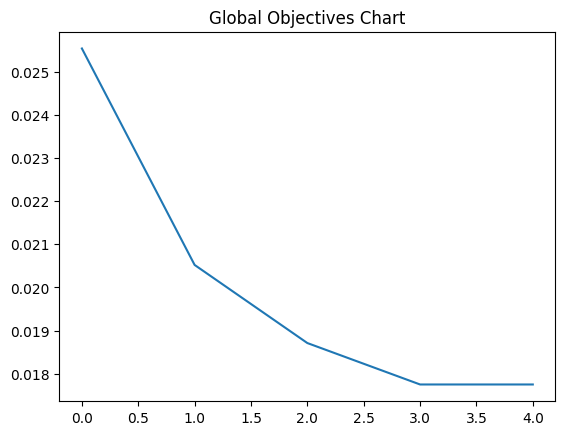

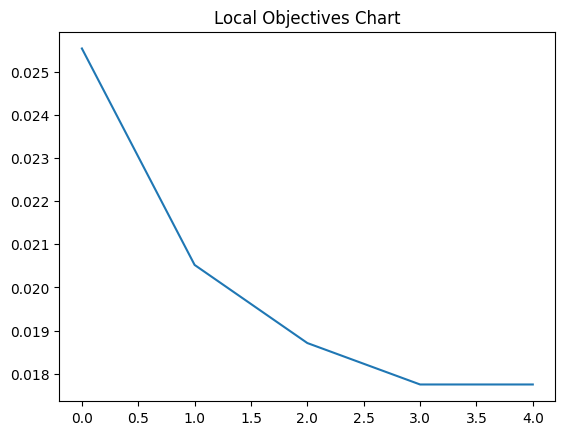

No handles with labels found to put in legend.


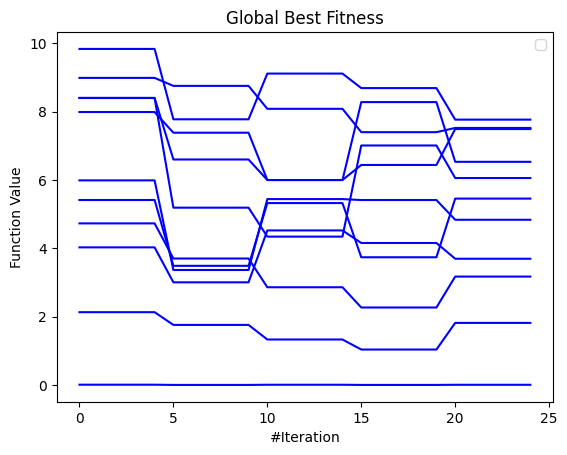

No handles with labels found to put in legend.


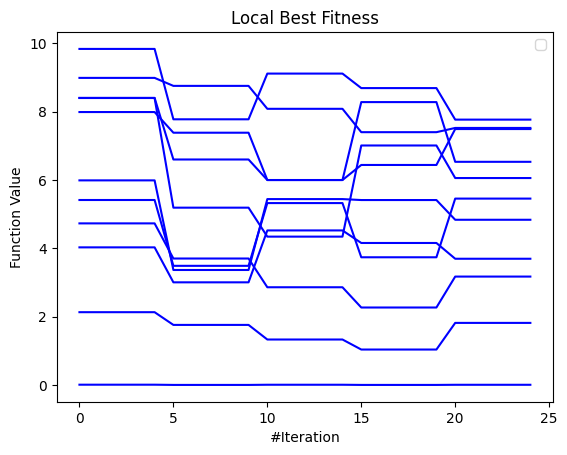

No handles with labels found to put in legend.


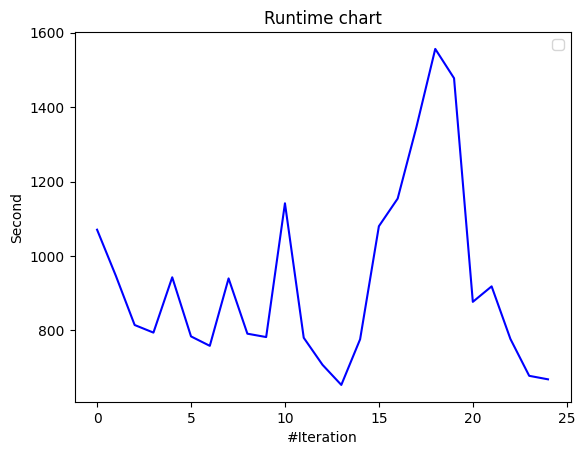

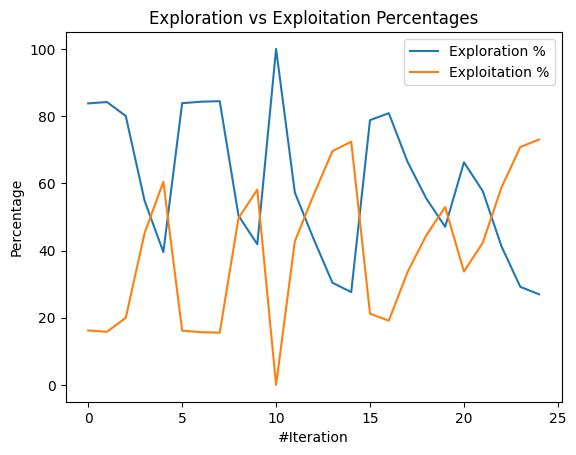

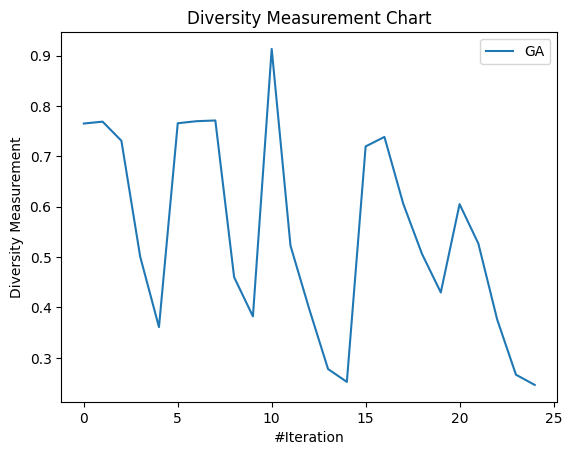

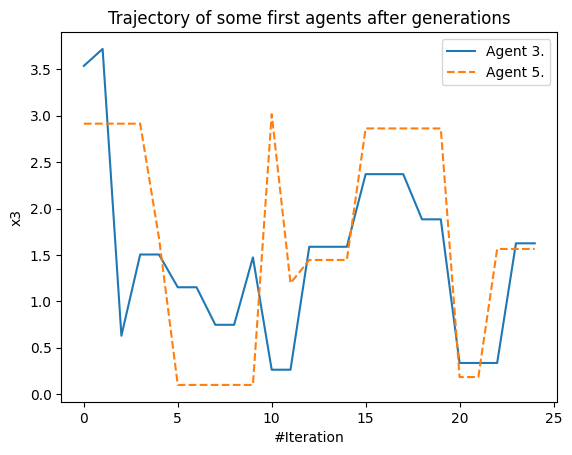

In [22]:
model.history.save_global_objectives_chart(filename="hello/goc")
model.history.save_local_objectives_chart(filename="hello/loc")

model.history.save_global_best_fitness_chart(filename="hello/gbfc")
model.history.save_local_best_fitness_chart(filename="hello/lbfc")

model.history.save_runtime_chart(filename="hello/rtc")

model.history.save_exploration_exploitation_chart(filename="hello/eec")

model.history.save_diversity_chart(filename="hello/dc")

model.history.save_trajectory_chart(list_agent_idx=[3, 5], selected_dimensions=[3], filename="hello/tc")

### Remove old sessions

In [17]:
if os.path.exists(session_file):
    os.remove(session_file)

In [47]:
for training in trainings_epochs:
    print(len(training["trainings"]))

0
1
60
60
60
60
60


In [27]:
import json
jd=[]
for training in trainings_epochs:
    json_data=[]
    for obj in training["trainings"]:
        training_obj=obj.__dict__
        samples=[]
        for sample in training_obj["samples"]:
            samples.append(sample)
        training_obj["samples"]=samples
        json_data.append(training_obj)
    jd.append(json_data)  

# Print the JSON data
print(jd)
# Convert the object to JSON
with open("output_ViT.json", "w") as file:
    file.write(json.dumps(jd, default=str))

[[{'title': 'Epoch Training', 'started': 1687209952.629058, 'params': {'inputShape': (256, 256, 1), 'latent_space_dim': 64, 'reducedDimension': 256, 'num_conv_layers': 6, 'learning_rate': 0.0012274341143625918, 'batch_size': 32, 'epochs': 20, 'opt': 'Adam', 'n_heads': 3, 'hidden_size': 128, 'enc_layers': 4}, 'ended': 1687210009.1827118, 'samples': [<__main__.Timer object at 0x0000025ED0824FD0>]}], [{'title': 'Epoch Training', 'started': 1687210171.690488, 'params': {'inputShape': (256, 256, 1), 'latent_space_dim': 64, 'reducedDimension': 256, 'num_conv_layers': 6, 'learning_rate': 0.005408180028453508, 'batch_size': 8, 'epochs': 20, 'opt': 'Adagrad', 'n_heads': 4, 'hidden_size': 64, 'enc_layers': 3}, 'ended': 1687210238.3223975, 'samples': [<__main__.Timer object at 0x0000025ED1B071F0>]}, {'title': 'Epoch Training', 'started': 1687210240.8549628, 'params': {'inputShape': (256, 256, 1), 'latent_space_dim': 64, 'reducedDimension': 128, 'num_conv_layers': 8, 'learning_rate': 0.00866391653

In [32]:
import json
jd=[]
for training in trainings_epochs:
    json_data=[]
    for obj in training["trainings"]:
        training_obj=obj.__dict__
        samples=[]
        for sample in training_obj["samples"]:
            samples.append(sample.__dict__)
        training_obj["samples"]=samples
        json_data.append(training_obj)
    jd.append(json_data)  

# Print the JSON data
print(jd)
# Convert the object to JSON
with open("output.json", "w") as file:
    file.write(json.dumps(jd))

[[{'title': 'Epoch Training', 'started': 1687209952.629058, 'params': {'inputShape': (256, 256, 1), 'latent_space_dim': 64, 'reducedDimension': 256, 'num_conv_layers': 6, 'learning_rate': 0.0012274341143625918, 'batch_size': 32, 'epochs': 20, 'opt': 'Adam', 'n_heads': 3, 'hidden_size': 128, 'enc_layers': 4}, 'ended': 1687210009.1827118, 'samples': [<__main__.Timer object at 0x0000025ED0824FD0>]}], [{'title': 'Epoch Training', 'started': 1687210171.690488, 'params': {'inputShape': (256, 256, 1), 'latent_space_dim': 64, 'reducedDimension': 256, 'num_conv_layers': 6, 'learning_rate': 0.005408180028453508, 'batch_size': 8, 'epochs': 20, 'opt': 'Adagrad', 'n_heads': 4, 'hidden_size': 64, 'enc_layers': 3}, 'ended': 1687210238.3223975, 'samples': [<__main__.Timer object at 0x0000025ED1B071F0>]}, {'title': 'Epoch Training', 'started': 1687210240.8549628, 'params': {'inputShape': (256, 256, 1), 'latent_space_dim': 64, 'reducedDimension': 128, 'num_conv_layers': 8, 'learning_rate': 0.00866391653

In [19]:
histories = []
for i in range(len(learnedVoxels)):
    print(f"currently working one voxel : {i +1}, voxels left : {len(learnedVoxels)-(i+1)} ")
    histories.append(Reconstruction.train(learnedVoxels[i],inferenceVoxels[i]))

currently working one voxel : 1, voxels left : 57 


TypeError: train() missing 1 required positional argument: 'inputs2'

## Testing the model

### Load test data

In [ ]:
X_test=np.load('X_test.npy')
X_test.shape

In [48]:
first  = X_test[0]
Topredict = first[1:]
test = first[:-1]

In [ ]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
# reconstruction.Generate.save('reconstruction_10batch_10epochs.h5')

In [ ]:
file_path = "reconstructed.raw"
testing.insert(0, first[0].reshape(1,256,256,1))
print(len(testing))

In [ ]:
final = np.array(testing,np.float32).reshape(250,256,256)
final.shape

In [ ]:
file_path = "my_array.npy"
np.save("file", final)

In [ ]:
final.tofile(file_path)

In [ ]:
Volume = np.fromfile(file_path, dtype=np.uint8)
Volume = Volume.reshape(250,256,256)
Volume.shape